In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython
import time
from torch.utils.data import Dataset
import random
import torch
import torchvision
import torchaudio
from torch.utils.data import DataLoader
import sys
sys.path.append("..")
from dataset_generation.randomDataset import RandomDataset

from utils.cnn import CNNNetwork
from utils.lstm import LSTMNetwork
from utils import LABELS
from utils.numpyDataset import NumpyDataset
from utils.augmentation import AudioAugmentation
print(LABELS)

['Amos', 'Kailash', 'Cyprian', 'Selena', 'Aneri', 'Dylan', 'Jennifer']


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
loss = torch.nn.CrossEntropyLoss()

src = '../dataset_generation/denoised_speeches'
nfft=512
nmels = 50

aug = AudioAugmentation(sample_rate=16000)

augmentations = [
    ("volume_adjustment", {'factor': 1.1}),
    ("volume_adjustment", {'factor': 0.9}),
    ("volume_adjustment", {'factor': 1.3}),
    ("volume_adjustment", {'factor': 0.7}),
    ("highpass_filter", {'cutoff_freq': 100}),
    ("highpass_filter", {'cutoff_freq': 200}),
    ("lowpass_filter", {'cutoff_freq': 3000}),
    ("lowpass_filter", {'cutoff_freq': 6000})
]
spec = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=nfft, n_mels=60)

def transform(wav):
    a1 = random.sample(augmentations, 1)[0]
    wav = aug.apply(wav, a1)
    
    return spec(wav)


dataSet = RandomDataset(src, 16000, 10000, transform, 6, 5)

train_data, val_data = torch.utils.data.random_split(dataSet, (0.8, 0.2))
input_shape = dataSet[0][0].shape
train_dl = DataLoader(train_data, batch_size=64)
val_dl = DataLoader(val_data, batch_size=64)

print(input_shape)

cuda
torch.Size([1, 60, 313])


In [8]:
import torchvision.models as models
import torch.nn as nn 

## USE THIS OR RESNET
model = CNNNetwork(7, input_shape=input_shape, layers=[16, 32, 64, 128], stride=(1, 2))
model(torch.rand(1, *input_shape))

model = model.to(device)


#Load the pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained=True)
# Set all parameters in the model to non-trainable (requires_grad=False)
for param in resnet18.parameters():
    param.requires_grad = False

resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-1])
new_fc =  torch.nn.Linear(512, 7)
new_layers = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    new_fc,
    nn.Softmax(dim=1))
resnet18_modified = nn.Sequential(
    resnet18,
    new_layers
)


model = resnet18_modified.to(device)
print(model)
optimizer = torch.optim.Adam(new_layers.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()

194752
torch.Size([1, 1, 60, 313])
torch.Size([1, 16, 31, 79])
torch.Size([1, 32, 16, 20])
torch.Size([1, 64, 9, 5])
torch.Size([1, 128, 5, 2])
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 

In [9]:
def train_epoch(model, train_data_loader, val_data_loader, loss_fn, opt, device, metrics):

    model.train()
    losses = []
    accuracies = []
    for input, target in train_data_loader:
        input, target = input.to(device), target.to(device)
        input = torch.cat((input, input, input), dim=1)
        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, target)
        _, preds = torch.max(prediction.data, 1)
        accuracies.append((preds == target).float().mean())
        losses.append(loss.item())
        # backpropagate error and update weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    metrics['t_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['t_loss'].append((sum(losses)/sum(accuracies)).cpu())
    
    model.eval()
    losses = []
    accuracies = []
    for input, target in val_data_loader:
        input, target = input.to(device), target.to(device)
        input = torch.cat((input, input, input), dim=1)
        prediction = model(input)
        loss = loss_fn(prediction, target)
        _, preds = torch.max(prediction.data, 1)
        accuracies.append((preds == target).float().mean())
        losses.append(loss.item())
    
    metrics['v_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['v_loss'].append((sum(losses)/sum(accuracies)).cpu())

In [10]:
metrics = {
    't_loss': [],
    'v_loss': [],
    't_acc': [],
    'v_acc': []
}
print('****** STARTING TRAINING ******')
for epoch in range(50):
    train_epoch(model, train_dl, val_dl, loss_fn=loss, opt=optimizer, device=device, metrics=metrics)
    print(f"Finished epoch: {epoch} Val loss: {metrics['v_loss'][-1]}, Val acc: {metrics['v_acc'][-1]}")

print("Fininshed training")    
print('best validation accuracy', max(metrics['v_acc']).data)

plt.plot(metrics['t_loss'])
plt.plot(metrics['v_loss'])
plt.legend(['training', 'validation'])
plt.title('cross entropy loss')
plt.show()

plt.figure(1)
plt.plot(metrics['t_acc'])
plt.plot(metrics['v_acc'])
plt.legend(['training', 'validation'])
plt.title('accuracy')

****** STARTING TRAINING ******
Finished epoch: 0 Val loss: 5.669223308563232, Val acc: 0.3310546875
Finished epoch: 1 Val loss: 4.1342854499816895, Val acc: 0.43701171875
Finished epoch: 2 Val loss: 3.191932439804077, Val acc: 0.54931640625
Finished epoch: 3 Val loss: 2.750246047973633, Val acc: 0.62109375
Finished epoch: 4 Val loss: 2.5608129501342773, Val acc: 0.6513671875
Finished epoch: 5 Val loss: 2.5621602535247803, Val acc: 0.6435546875
Finished epoch: 6 Val loss: 2.466479778289795, Val acc: 0.65869140625
Finished epoch: 7 Val loss: 2.5288777351379395, Val acc: 0.642578125
Finished epoch: 8 Val loss: 2.459805965423584, Val acc: 0.65478515625
Finished epoch: 9 Val loss: 2.34130597114563, Val acc: 0.67626953125
Finished epoch: 10 Val loss: 2.323173761367798, Val acc: 0.67919921875
Finished epoch: 11 Val loss: 2.32222843170166, Val acc: 0.67626953125
Finished epoch: 12 Val loss: 2.156836986541748, Val acc: 0.71240234375
Finished epoch: 13 Val loss: 2.1764845848083496, Val acc: 0.7

KeyboardInterrupt: 

In [ ]:
params = ""
torch.save(model.state_dict(), params)

True label was Amos. Prediction was Jennifer with tensor([0.5082], device='cuda:0') confidence
True label was Aneri. Prediction was Jennifer with tensor([0.9991], device='cuda:0') confidence
True label was Cyprian. Prediction was Jennifer with tensor([0.8769], device='cuda:0') confidence
True label was Jennifer. Prediction was Dylan with tensor([0.3982], device='cuda:0') confidence
True label was Kailash. Prediction was Jennifer with tensor([0.9032], device='cuda:0') confidence
True label was Amos. Prediction was Dylan with tensor([0.9783], device='cuda:0') confidence
True label was Aneri. Prediction was Jennifer with tensor([0.9641], device='cuda:0') confidence
True label was Cyprian. Prediction was Dylan with tensor([0.9616], device='cuda:0') confidence
True label was Dylan. Prediction was Jennifer with tensor([0.6987], device='cuda:0') confidence
True label was Kailash. Prediction was Dylan with tensor([0.9791], device='cuda:0') confidence
True label was Selena. Prediction was Dylan

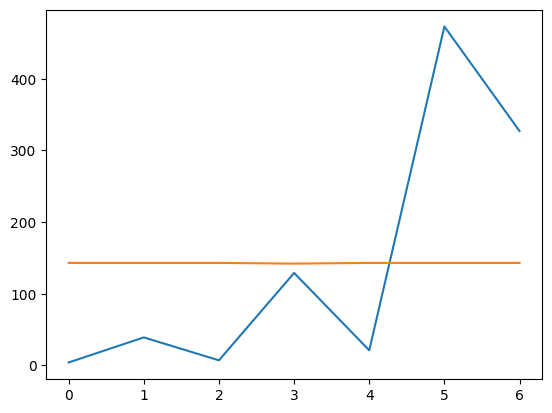

In [12]:
src = '../dataset_generation/test_data_overheard_resampled/'
model.eval()
model = model.to(device)
test = RandomDataset(src, 16000, 1000, transform, 6, 5)
testDl = DataLoader(test, batch_size=1)

correct = 0
total = 0
preds_distribution = np.zeros(7)
correct_distribution = np.zeros(7)
for input, target in testDl:
    input, target = input.to(device), target.to(device)
    
    input = torch.cat((input, input, input), dim=1)
    #print(input.shape)
    #raise
    prediction = model(input)
    confidence, preds = torch.max(prediction.data, 1)

    if preds == target:
        correct += 1
    else:
        pass
        print(f'True label was {LABELS[target]}. Prediction was {LABELS[preds]} with {confidence.data} confidence')
    total += 1
    preds_distribution[preds.data] += 1
    correct_distribution[target.data] += 1

print('accuracy', correct/total)
plt.plot(preds_distribution)
plt.plot(correct_distribution)